In [1]:
import os

from PIL import Image
import cv2
import json
import string
from unidecode import unidecode

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

import keras_ocr

# Recognition

## Dataset

In [2]:
DATASET_PATH = '../data/autoriaNumberplateOcrEu-2021-09-27/autoriaNumberplateOcrEu-2021-09-27'
N_IMAGES = 10000

In [3]:
def unidecode_file_name(path, filename):
    decoded_filename = unidecode(filename)
    if filename != decoded_filename:
        full_path = os.path.abspath(path + '/' + filename)
        decoded_filename = decoded_filename.replace(r'\\', '-')
        decoded_filename = decoded_filename.replace(r'/', '-')
        decoded_path = os.path.abspath(path + '/' + decoded_filename)
        os.rename(full_path, decoded_path)
        
for path_addon in ['/train/img', '/val/img', '/train/ann', '/val/ann']:
    path = DATASET_PATH + path_addon
    for file_name in os.listdir(path):
        unidecode_file_name(path, file_name)

In [4]:
def load_images(path, n=None):
    images = []
    for file_name in os.listdir(path)[:n]:
        image = np.array(Image.open(path + '/' + file_name))[:, :, :3]
        image = cv2.resize(image, dsize=(186, 40))
        images.append(image)
    return np.array(images)

def load_image_paths(path, n=None):
    images = []
    for file_name in os.listdir(path)[:n]:
        images.append(path + '/' + file_name)
    return np.array(images)

def load_texts(path, n=None):
    texts = []
    for file_name in os.listdir(path)[:n]:
        with open(path + '/' + file_name, encoding='utf8') as file:
            data = json.load(file)
            texts.append(data['description'])
    return np.array(texts)

In [5]:
train_images, test_images = load_image_paths(DATASET_PATH + '/train/img', N_IMAGES), load_image_paths(DATASET_PATH + '/val/img')

train_images.shape, test_images.shape

((10000,), (788,))

In [6]:
train_texts, test_texts = load_texts(DATASET_PATH + '/train/ann', N_IMAGES), load_texts(DATASET_PATH + '/val/ann')

train_texts[:4], test_texts[:4]

(array(['0005IK', 'H040077', '0010HXB', '001SCE'], dtype='<U9'),
 array(['ZH933108', '7VTG00', '7VTG00', '7U98500'], dtype='<U9'))

In [7]:
train_labels = [(filepath, None, text) for filepath, text in zip(train_images, train_texts)]
test_labels = [(filepath, None, text) for filepath, text in zip(test_images, test_texts)]

## Recognizer

In [8]:
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits + string.ascii_uppercase)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\MatiX\.keras-ocr\crnn_kurapan_notop.h5


## Generator

In [9]:
batch_size = 128

# train
training_image_gen = keras_ocr.datasets.get_recognizer_image_generator(
    labels=train_labels,
    height=recognizer.model.input_shape[1],
    width=recognizer.model.input_shape[2],
    alphabet=string.digits + string.ascii_uppercase
)
training_steps = len(train_labels) // batch_size

training_gen = recognizer.get_batch_generator(
    image_generator=training_image_gen,
    batch_size=batch_size
)

# test
testing_image_gen = keras_ocr.datasets.get_recognizer_image_generator(
    labels=test_labels,
    height=recognizer.model.input_shape[1],
    width=recognizer.model.input_shape[2],
    alphabet=string.digits + string.ascii_uppercase
)
testing_steps = len(test_labels) // batch_size

testing_gen = recognizer.get_batch_generator(
    image_generator=testing_image_gen,
    batch_size=batch_size
)

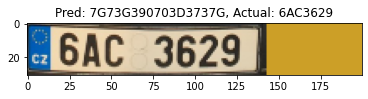

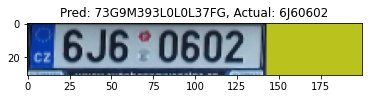

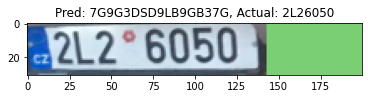

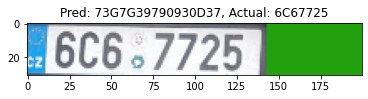

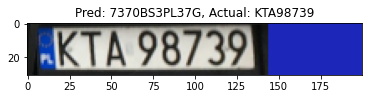

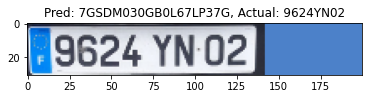

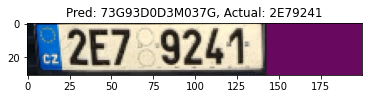

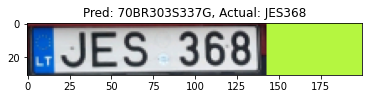

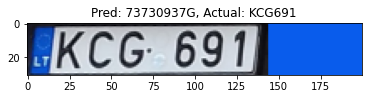

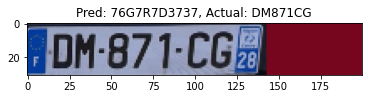

In [10]:
N = 10
test_images, test_texts = zip(*[next(testing_image_gen) for _ in range(N)])

for image, text in zip(test_images, test_texts):
    pred_text = recognizer.recognize(image)

    plt.imshow(image)
    plt.title(f'Pred: {pred_text}, Actual: {text}')
    plt.show()

## Training

In [11]:
callbacks = [
]

recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=testing_steps,
    validation_data=testing_gen,
    callbacks=callbacks,
    epochs=5
)

C:\Users\MatiX\AppData\Local\Temp\ipykernel_17168\3729065030.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  recognizer.training_model.fit_generator(


Epoch 1/5
78/78 [==============================] - 98s 1s/step - loss: 17.3360 - val_loss: 2.4732
Epoch 2/5
78/78 [==============================] - 71s 913ms/step - loss: 0.8492 - val_loss: 0.6915
Epoch 3/5
78/78 [==============================] - 81s 1s/step - loss: 0.2014 - val_loss: 0.4618
Epoch 4/5
78/78 [==============================] - 78s 1s/step - loss: 0.1325 - val_loss: 0.4741
Epoch 5/5
78/78 [==============================] - 79s 1s/step - loss: 0.1453 - val_loss: 0.4527


## Test

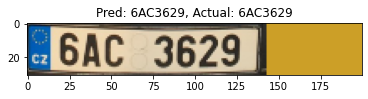

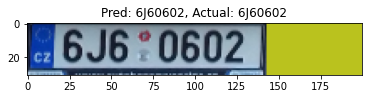

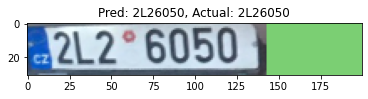

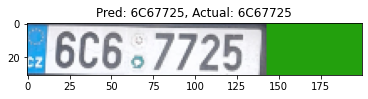

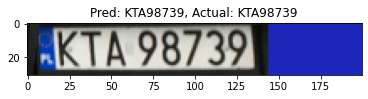

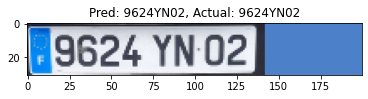

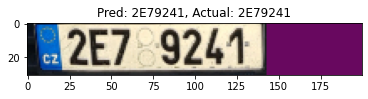

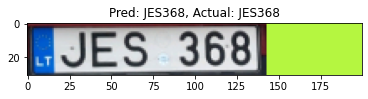

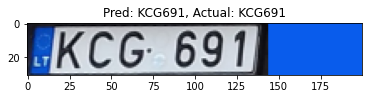

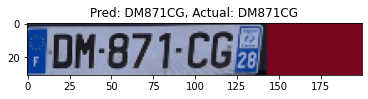

In [12]:
for image, text in zip(test_images, test_texts):
    pred_text = recognizer.recognize(image)

    plt.imshow(image)
    plt.title(f'Pred: {pred_text}, Actual: {text}')
    plt.show()

# Parking test

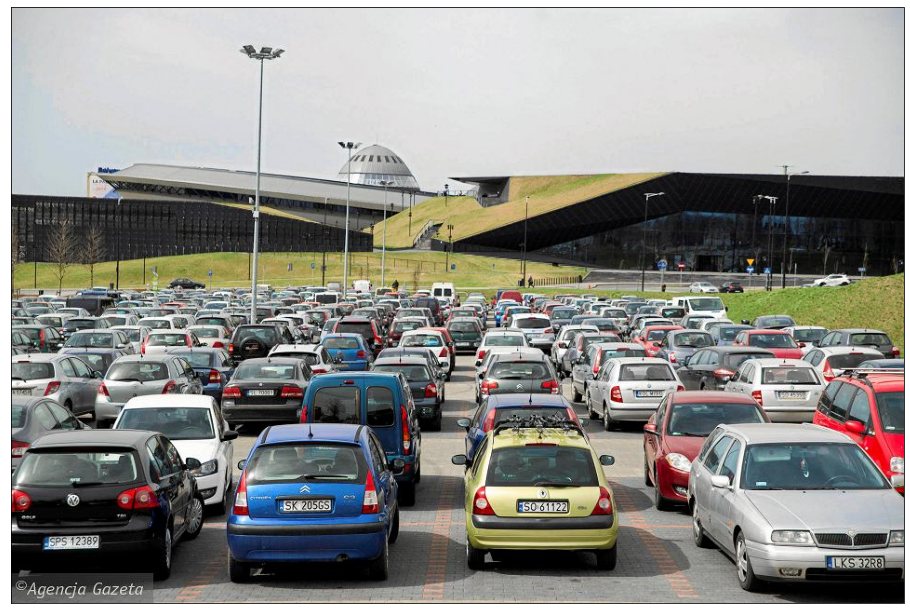

In [17]:
IMAGE_PATH_PARKING = '../data/parking.jpg'

img = keras_ocr.tools.read(IMAGE_PATH_PARKING)

plt.figure(figsize=(16, 12))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

### Default

Looking for C:\Users\MatiX\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\MatiX\.keras-ocr\crnn_kurapan.h5


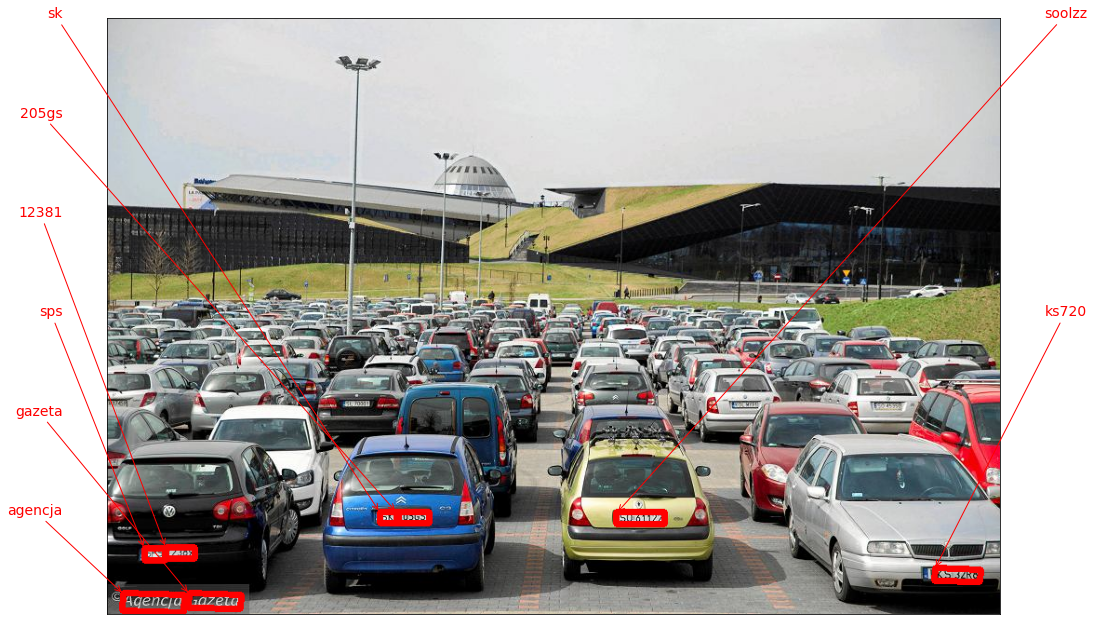

In [18]:
pipeline = keras_ocr.pipeline.Pipeline()

prediction_groups = pipeline.recognize([img])

plt.figure(figsize=(16, 12))
ax = plt.subplot(1, 1, 1)
keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0], ax=ax)
plt.show()

### Fine-tuned

Looking for C:\Users\MatiX\.keras-ocr\craft_mlt_25k.h5


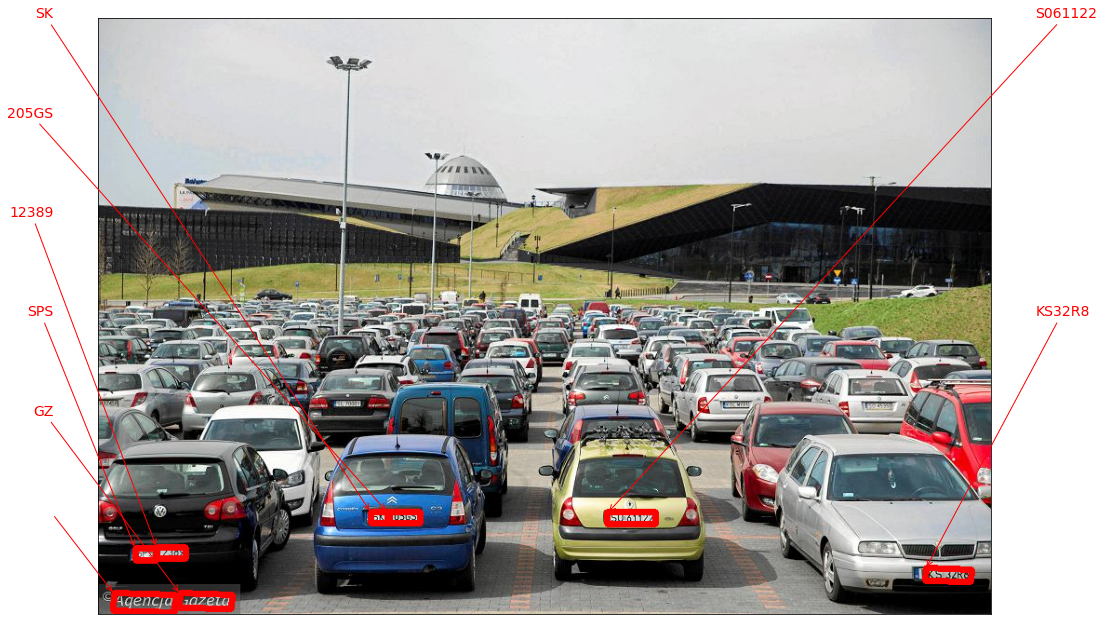

In [19]:
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)

IMAGE_PATH_PARKING = '../data/parking.jpg'

img = keras_ocr.tools.read(IMAGE_PATH_PARKING)

prediction_groups = pipeline.recognize([img])

plt.figure(figsize=(16, 12))
ax = plt.subplot(1, 1, 1)
keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0], ax=ax)
plt.show()